Updated by Leonardo Porcacchia on 08-10-2021. Email: leonardo.porcacchia@gmail.com

### Import libraries

In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
import gc
import glob

import csv
import pandas as pd

from datetime import date, timedelta, datetime

import h5py
import netCDF4 as nc
from netCDF4 import Dataset as netcdf_dataset

from pyproj import Proj, Geod
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from windrose import WindroseAxes

from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches

In [2]:
%matplotlib notebook 
%matplotlib inline

### ERA5 Data

In [3]:
DATA_PATH = "C:/Users/leona/Desktop/Data/"  #path to where ERA5 data are stored
OUT_PATH = "C:/Users/leona/Desktop/Plots/"  #path to where save plots

### Extract ERA5 variables from files I previously dowlnloaeded from Copernicus portal
https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset

#### This file contains the following variables for May, June, July 2019 and 2020:
- sea surface temperature
- atmospheric temperature at 2m
- wind speed components u and v at 10m and 100m
- mean sea level pressure
- surface sensible heat flux
- boundary layer height
- convective available energy (CAPE)

In [4]:
file_nc = DATA_PATH + 'North_Sea_2019_2020.nc'

In [5]:
print(file_nc)

C:/Users/leona/Desktop/Data/North_Sea_2019_2020.nc


In [6]:
### To print out variables
#netcdf_dataset(file_nc).variables

In [7]:
sst = netcdf_dataset(file_nc).variables['sst'][:]         #sea surf temp                                                     #(I dowloaded this later)
ta = netcdf_dataset(file_nc).variables['t2m'][:]          #2m temperature
u10m = netcdf_dataset(file_nc).variables['u10'][:]        #10m velocity u component
v10m = netcdf_dataset(file_nc).variables['v10'][:]        #10m velocity v component 
u100m = netcdf_dataset(file_nc).variables['u100'][:]      #10m velocity u component
v100m = netcdf_dataset(file_nc).variables['v100'][:]      #10m velocity v component 
pa = netcdf_dataset(file_nc).variables['msl'][:]          #mean sea level pressure
ishf = netcdf_dataset(file_nc).variables['ishf'][:]       #surface sensisble heat flux 
blh = netcdf_dataset(file_nc).variables['blh'][:]         #boundary layer height
cape = netcdf_dataset(file_nc).variables['cape'][:]       #convective available potential energy

In [8]:
### Time in hours since 1/1/1990
hours = netcdf_dataset(file_nc).variables['time'][:]
print(hours)

[1046016 1046017 1046018 ... 1057005 1057006 1057007]


In [9]:
### Convert all hours since 1/1/1990 to datetime
start = datetime(1900,1,1,0,0,0) 
my_dates = []

for i in np.arange(0,len(hours)):
    
    my_hours = int(hours.data[i])
    delta = timedelta(hours=my_hours) 
    offset = start + delta
    #print(offset)
       
    my_dates = np.concatenate((my_dates, offset), axis=None)

print(my_dates)

[datetime.datetime(2019, 5, 1, 0, 0) datetime.datetime(2019, 5, 1, 1, 0)
 datetime.datetime(2019, 5, 1, 2, 0) ...
 datetime.datetime(2020, 7, 31, 21, 0)
 datetime.datetime(2020, 7, 31, 22, 0)
 datetime.datetime(2020, 7, 31, 23, 0)]


In [10]:
### Extract lon, lat
lon = netcdf_dataset(file_nc).variables['longitude'][:].data
lat = netcdf_dataset(file_nc).variables['latitude'][:].data
print(lon)
print(lat)

[3.25 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5
 6.75 7.  ]
[54.25 54.   53.75 53.5  53.25 53.   52.75 52.5  52.25 52.   51.75 51.5
 51.25 51.  ]


#### This file contains precipitation and cloud cover data

In [11]:
file_nc_prec = DATA_PATH + 'North_Sea_2019_2020_prec.nc'

In [12]:
#netcdf_dataset(file_nc_prec).variables

In [13]:
tcc = netcdf_dataset(file_nc_prec).variables['tcc'][:]         #total cloud cover                                                     #(I dowloaded this later)
tp = netcdf_dataset(file_nc_prec).variables['tp'][:]           #total precipitation

#### This file contains wind speed components at 500 and 925 hPa pressure levels 

In [14]:
file_nc_geo = DATA_PATH + 'North_Sea_2019_2020_geo.nc'

In [15]:
#netcdf_dataset(file_nc_geo).variables

In [16]:
level = netcdf_dataset(file_nc_geo).variables['level'][:]         #hPa level                                                     #(I dowloaded this later)
u_lev = netcdf_dataset(file_nc_geo).variables['u'][:]             #u comppnent of wind at level
v_lev = netcdf_dataset(file_nc_geo).variables['v'][:]             #v component of wind at level 
print(level)

[500 925]


### Time Series Analysis

### IJmuiden

In [17]:
### Define an interval
ref_date_1 = datetime(2020,7,1,0,0,0)
ref_date_2 = datetime(2020,7,31,23,0,0)

time_idx = np.where(np.all([my_dates>=ref_date_1,my_dates<=ref_date_2],axis=0))
#print(my_dates[time_idx[0]])   

In [18]:
### Select the pixels corresponding to IJmuiden coordinates and calculate the average of interesting variables
idx_lat_1 = np.where(np.all([lat>=52.5,lat<=53],axis=0))
print(lat[idx_lat_1])
idx_lon_1 = np.where(np.all([lon>=3.75,lon<=4.25],axis=0))
print(lon[idx_lon_1])

cape_uno = np.average(cape[:,:,idx_lon_1[0]],axis=2)
print(np.shape(cape_uno))
cape_due = np.average(cape_uno[:,idx_lat_1[0]],axis=1)
print(np.shape(cape_due))
cape_IJ = cape_due[time_idx[0]]
print(np.shape(cape_IJ))

blh_uno = np.average(blh[:,:,idx_lon_1[0]],axis=2)
blh_due = np.average(blh_uno[:,idx_lat_1[0]],axis=1)
blh_IJ = blh_due[time_idx[0]]

ishf_uno = np.average(-ishf[:,:,idx_lon_1[0]],axis=2)
ishf_due = np.average(ishf_uno[:,idx_lat_1[0]],axis=1)
ishf_IJ = ishf_due[time_idx[0]]

deltat = sst - ta
deltat_uno = np.average(deltat[:,:,idx_lon_1[0]],axis=2)
deltat_due = np.average(deltat_uno[:,idx_lat_1[0]],axis=1)
deltat_IJ = deltat_due[time_idx[0]]

ta_uno = np.average(ta[:,:,idx_lon_1[0]],axis=2)
ta_due = np.average(ta_uno[:,idx_lat_1[0]],axis=1)
ta_IJ = ta_due[time_idx[0]]

sst_uno = np.average(sst[:,:,idx_lon_1[0]],axis=2)
sst_due = np.average(sst_uno[:,idx_lat_1[0]],axis=1)
sst_IJ = sst_due[time_idx[0]]

u10m_uno = np.average(u10m[:,:,idx_lon_1[0]],axis=2)
u10m_due = np.average(u10m_uno[:,idx_lat_1[0]],axis=1)
u10m_IJ = u10m_due[time_idx[0]]

v10m_uno = np.average(v10m[:,:,idx_lon_1[0]],axis=2)
v10m_due = np.average(v10m_uno[:,idx_lat_1[0]],axis=1)
v10m_IJ = v10m_due[time_idx[0]]

u100m_uno = np.average(u100m[:,:,idx_lon_1[0]],axis=2)
u100m_due = np.average(u100m_uno[:,idx_lat_1[0]],axis=1)
u100m_IJ = u100m_due[time_idx[0]]

u925_uno = np.average(u_lev[:,:,:,idx_lon_1[0]],axis=3)
print(np.shape(u925_uno))
u925_due = np.average(u925_uno[:,:,idx_lat_1[0]],axis=2)
print(np.shape(u925_due))
u925_IJ = u925_due[time_idx[0],1]
print(np.shape(u925_IJ))

v100m_uno = np.average(v100m[:,:,idx_lon_1[0]],axis=2)
v100m_due = np.average(v100m_uno[:,idx_lat_1[0]],axis=1)
v100m_IJ = v100m_due[time_idx[0]]

v925_uno = np.average(v_lev[:,:,:,idx_lon_1[0]],axis=3)
#print(np.shape(u925_uno))
v925_due = np.average(v925_uno[:,:,idx_lat_1[0]],axis=2)
#print(np.shape(u925_due))
v925_IJ = v925_due[time_idx[0],1]
#print(np.shape(u925_IJ))

pa_uno = np.average(pa[:,:,idx_lon_1[0]],axis=2)
pa_due = np.average(pa_uno[:,idx_lat_1[0]],axis=1)
pa_IJ = pa_due[time_idx[0]]

tcc_uno = np.average(tcc[:,:,idx_lon_1[0]],axis=2)
tcc_due = np.average(tcc_uno[:,idx_lat_1[0]],axis=1)
tcc_IJ = tcc_due[time_idx[0]]

tp_uno = np.average(tp[:,:,idx_lon_1[0]],axis=2)
tp_due = np.average(tp_uno[:,idx_lat_1[0]],axis=1)
tp_IJ = tp_due[time_idx[0]]

[53.   52.75 52.5 ]
[3.75 4.   4.25]
(4416, 14)
(4416,)
(744,)
(4416, 2, 14)
(4416, 2)
(744,)


### Plots

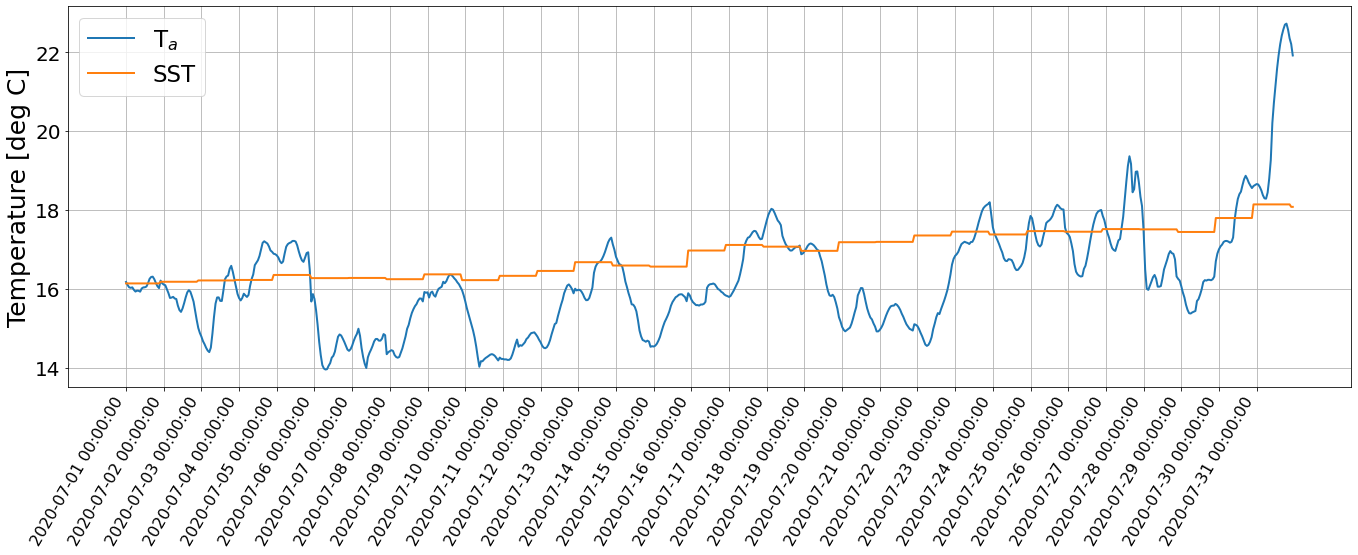

In [20]:
ta_IJ_C = ta_IJ - 273.15
sst_IJ_C = sst_IJ - 273.15 

plt.figure(figsize=(23,7))
plt.plot(ta_IJ_C,'-',linewidth=2,label='T$_a$')
plt.plot(sst_IJ_C,'-',linewidth=2,label='SST')

vec = np.arange(len(time_idx[0]))
plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
plt.ylabel('Temperature [deg C]',fontsize=25)
plt.xlabel('')
plt.legend(fontsize=23)

ax = plt.gca()
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

### Uncomment here to save figure
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'temp_time_series_202007_IJ.png') #, facecolor='white')

Notes: 
- why is SST increasing almost linearly with time? Does it increase like this throughout all summer?
- difference of temperature is driven mostly by Ta

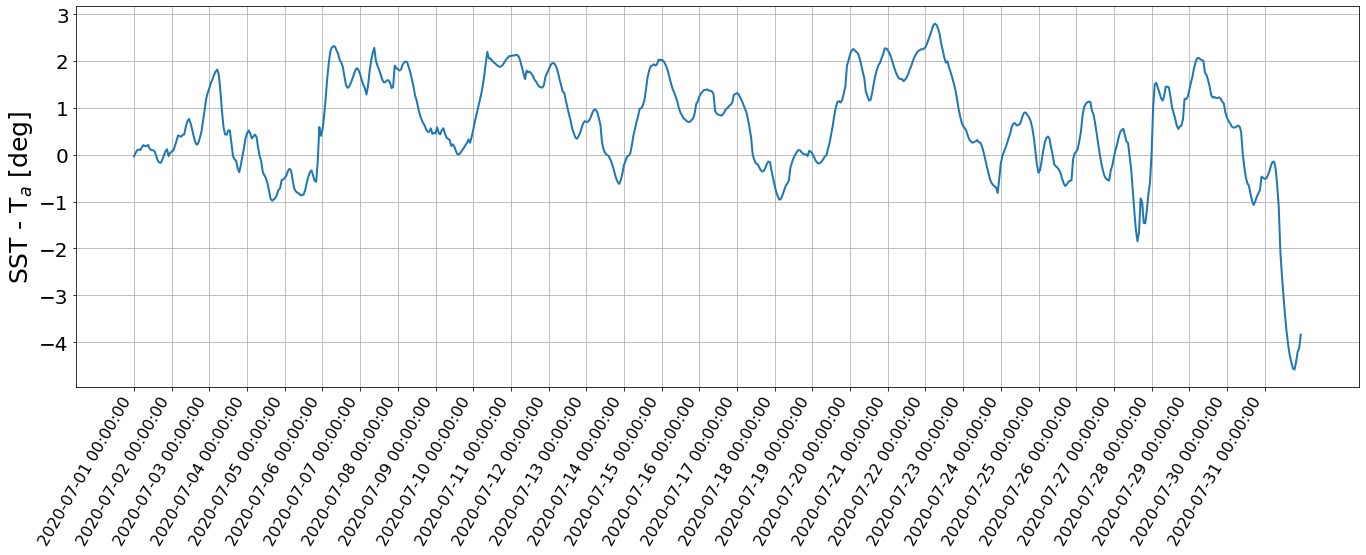

In [24]:
plt.figure(figsize=(23,7))
plt.plot(deltat_IJ,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('SST - T$_a$ [deg]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'deltat_time_series_202007_IJ.png') #, facecolor='white')

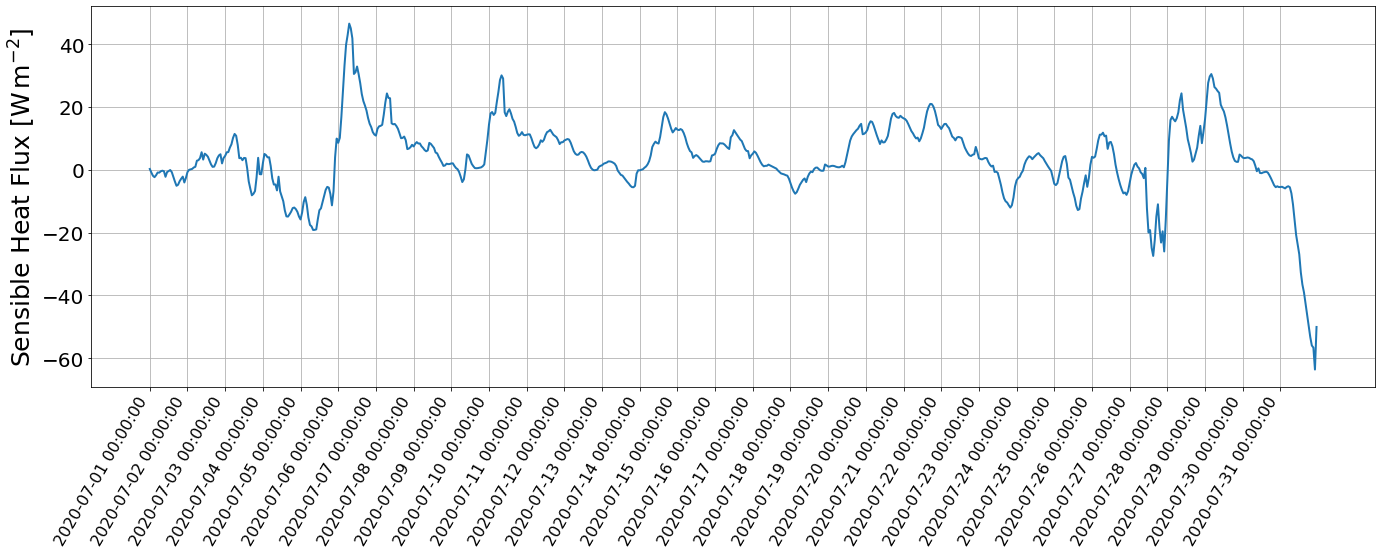

In [25]:
plt.figure(figsize=(23,7))
plt.plot(ishf_IJ,'-',linewidth=2,label='CAPE')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Sensible Heat Flux [W$\/$m$^{-2}$]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'ishf_time_series_202007_IJ.png') #, facecolor='white')

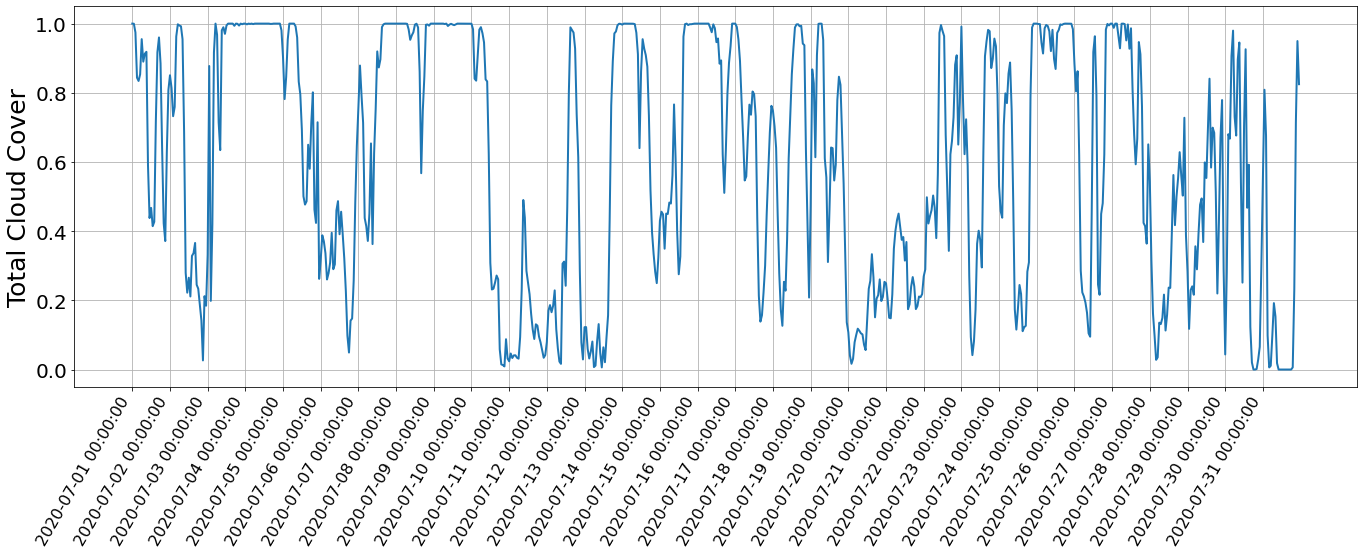

In [26]:
plt.figure(figsize=(23,7))
plt.plot(tcc_IJ,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Total Cloud Cover',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'tcc_time_series_202007_IJ.png') #, facecolor='white')

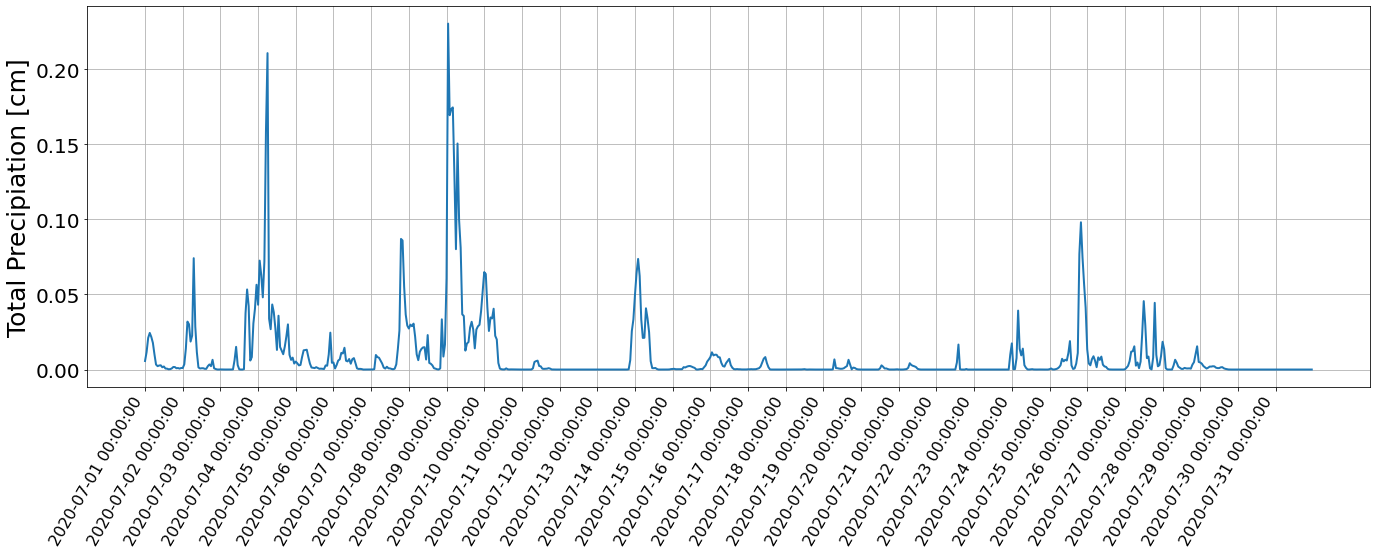

In [27]:
plt.figure(figsize=(23,7))
plt.plot(tp_IJ*100,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Total Precipiation [cm]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'tp_time_series_202007_IJ.png') #, facecolor='white')

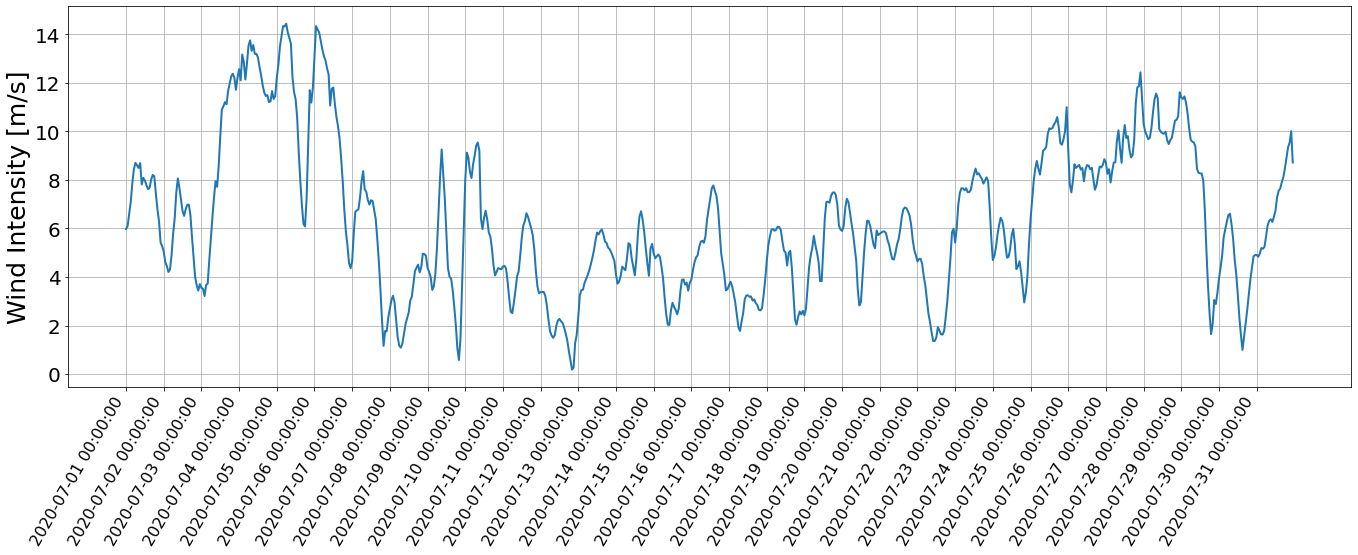

In [28]:
plt.figure(figsize=(23,7))
plt.plot(np.sqrt(u10m_IJ**2 + v10m_IJ**2),'-',linewidth=2,label='vel')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Wind Intensity [m/s]',fontsize=25)
ax.set_xlabel('')
#ax.legend(fontsize=23)

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'wind_time_series_202007_IJ.png') #, facecolor='white')

C:\Users\leona\AppData\Local\Temp/ipykernel_2856/1093731303.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(my_dates[time_idx[0]][t1:t2], rotation=60, ha='right',fontsize=16)


Text(0.5, 1.0, 'Wind speed and direction')

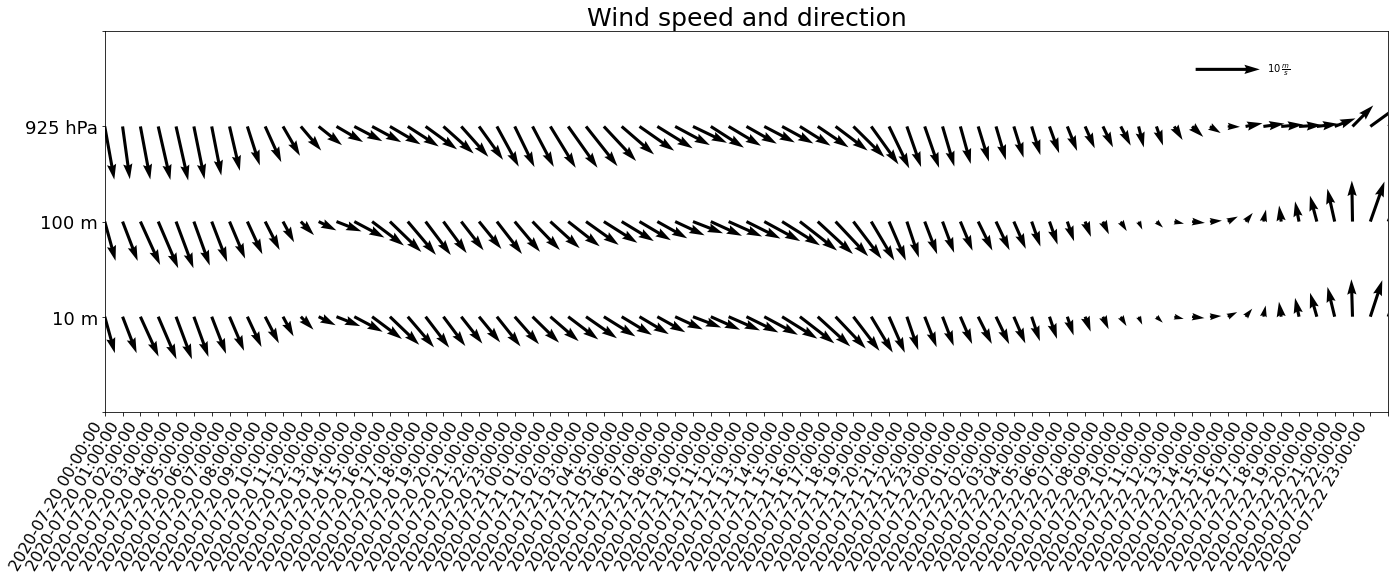

In [30]:
fig, ax = plt.subplots(1,1, figsize=(23,7))

t1 = 456 #index of starting time
t2 = 456 + 72 #index of ending time
numt = t2 - t1

y,x = np.meshgrid([1,2,3],vec)

Q = ax.quiver(x[:,0],y[:,0],u10m_IJ, v10m_IJ, pivot='tail',units='width',scale=200)
ax.quiverkey(Q, X=0.9, Y=0.9, U=10, label=r'$10\/\frac{m}{s}$',labelpos='E')
ax.quiver(x[:,1],y[:,1],u100m_IJ, v100m_IJ, pivot='tail',units='width',scale=200)
ax.quiver(x[:,2],y[:,2],u925_IJ, v925_IJ, pivot='tail',units='width',scale=200)

ax.set_xticklabels(my_dates[time_idx[0]][t1:t2], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=numt)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['','10 m','100 m','925 hPa',''],fontsize=18)

ax.set_ylim(0,4)
ax.set_xlim(t1,t2)
ax.set_title('Wind speed and direction',fontsize=25)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'wind_speed_dir_time_series_202007_IJ.png') #, facecolor='white')

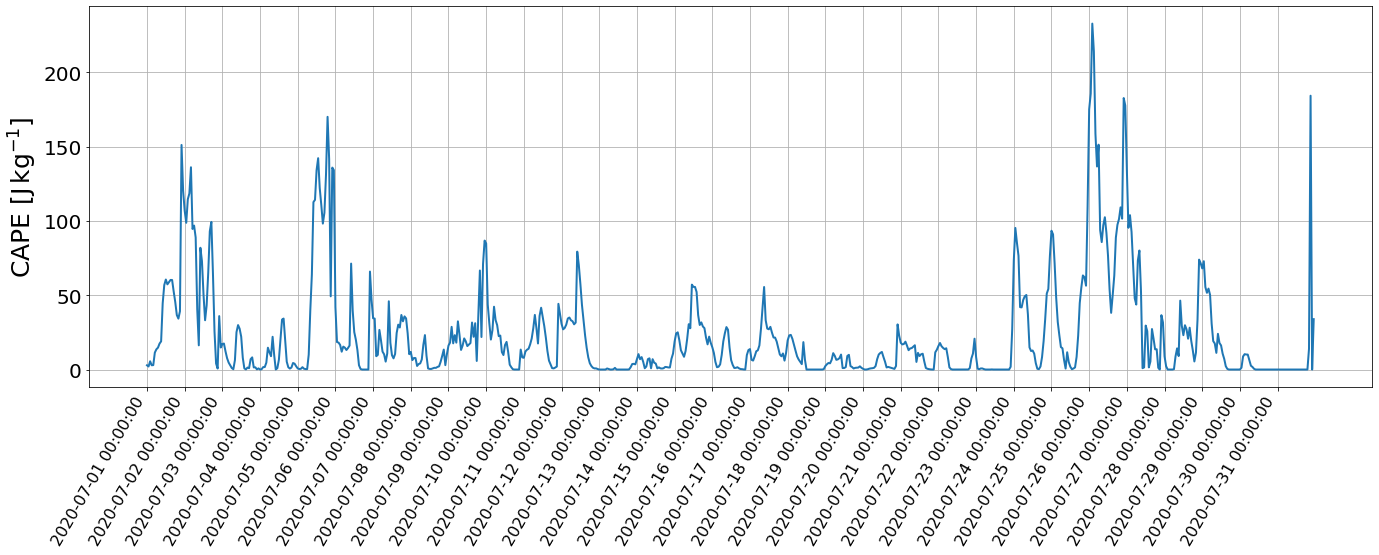

In [31]:
plt.figure(figsize=(23,7))
plt.plot(cape_IJ,'-',linewidth=2,label='CAPE')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('CAPE [J$\/$kg$^{-1}$]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'cape_time_series_202007_IJ.png') #, facecolor='white')

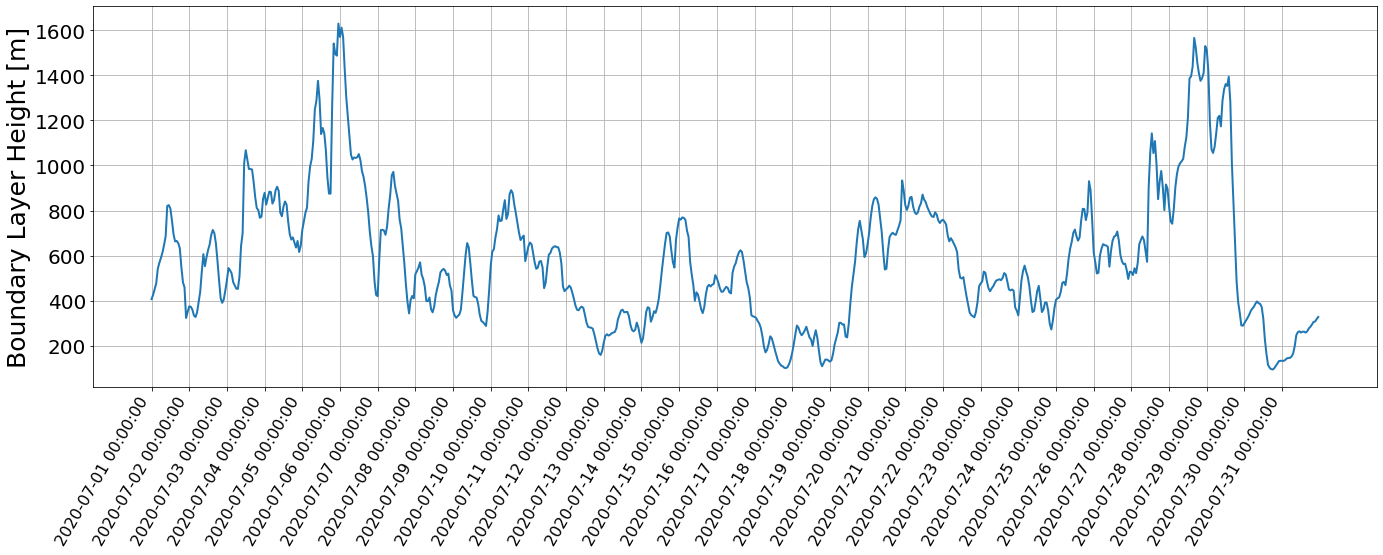

In [32]:
plt.figure(figsize=(23,7))
plt.plot(blh_IJ,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Boundary Layer Height [m]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'blh_time_series_202007_IJ.png') #, facecolor='white')

### Schiermonnikoog

In [33]:
ref_date_1 = datetime(2020,7,1,0,0,0)
ref_date_2 = datetime(2020,7,31,23,0,0)

time_idx = np.where(np.all([my_dates>=ref_date_1,my_dates<=ref_date_2],axis=0))
#print(my_dates[time_idx[0]])   

In [34]:
idx_lat_2 = np.where(np.all([lat>=53.75,lat<=54.25],axis=0))
print(lat[idx_lat_2])

idx_lon_2 = np.where(np.all([lon>=5.25,lon<=6.25],axis=0))
print(lon[idx_lon_2])

cape_uno = np.average(cape[:,:,idx_lon_2[0]],axis=2)
print(np.shape(cape_uno))
cape_due = np.average(cape_uno[:,idx_lat_2[0]],axis=1)
print(np.shape(cape_due))
cape_Sc = cape_due[time_idx[0]]
print(np.shape(cape_Sc))

blh_uno = np.average(blh[:,:,idx_lon_2[0]],axis=2)
blh_due = np.average(blh_uno[:,idx_lat_2[0]],axis=1)
blh_Sc = blh_due[time_idx[0]]

ishf_uno = np.average(-ishf[:,:,idx_lon_2[0]],axis=2)
ishf_due = np.average(ishf_uno[:,idx_lat_2[0]],axis=1)
ishf_Sc = ishf_due[time_idx[0]]

deltat = sst - ta
deltat_uno = np.average(deltat[:,:,idx_lon_2[0]],axis=2)
deltat_due = np.average(deltat_uno[:,idx_lat_2[0]],axis=1)
deltat_Sc = deltat_due[time_idx[0]]

ta_uno = np.average(ta[:,:,idx_lon_2[0]],axis=2)
ta_due = np.average(ta_uno[:,idx_lat_2[0]],axis=1)
ta_Sc = ta_due[time_idx[0]]

sst_uno = np.average(sst[:,:,idx_lon_2[0]],axis=2)
sst_due = np.average(sst_uno[:,idx_lat_2[0]],axis=1)
sst_Sc = sst_due[time_idx[0]]

u10m_uno = np.average(u10m[:,:,idx_lon_2[0]],axis=2)
u10m_due = np.average(u10m_uno[:,idx_lat_2[0]],axis=1)
u10m_Sc = u10m_due[time_idx[0]]

v10m_uno = np.average(v10m[:,:,idx_lon_2[0]],axis=2)
v10m_due = np.average(v10m_uno[:,idx_lat_2[0]],axis=1)
v10m_Sc = v10m_due[time_idx[0]]

u100m_uno = np.average(u100m[:,:,idx_lon_2[0]],axis=2)
u100m_due = np.average(u100m_uno[:,idx_lat_2[0]],axis=1)
u100m_Sc = u100m_due[time_idx[0]]

u925_uno = np.average(u_lev[:,:,:,idx_lon_2[0]],axis=3)
print(np.shape(u925_uno))
u925_due = np.average(u925_uno[:,:,idx_lat_2[0]],axis=2)
print(np.shape(u925_due))
u925_Sc = u925_due[time_idx[0],1]
print(np.shape(u925_IJ))

v100m_uno = np.average(v100m[:,:,idx_lon_2[0]],axis=2)
v100m_due = np.average(v100m_uno[:,idx_lat_2[0]],axis=1)
v100m_Sc = v100m_due[time_idx[0]]

v925_uno = np.average(v_lev[:,:,:,idx_lon_2[0]],axis=3)
v925_due = np.average(v925_uno[:,:,idx_lat_2[0]],axis=2)
v925_Sc = v925_due[time_idx[0],1]

pa_uno = np.average(pa[:,:,idx_lon_2[0]],axis=2)
pa_due = np.average(pa_uno[:,idx_lat_2[0]],axis=1)
pa_Sc = pa_due[time_idx[0]]

tcc_uno = np.average(tcc[:,:,idx_lon_2[0]],axis=2)
tcc_due = np.average(tcc_uno[:,idx_lat_2[0]],axis=1)
tcc_Sc = tcc_due[time_idx[0]]

tp_uno = np.average(tp[:,:,idx_lon_2[0]],axis=2)
tp_due = np.average(tp_uno[:,idx_lat_2[0]],axis=1)
tp_Sc = tp_due[time_idx[0]]

[54.25 54.   53.75]
[5.25 5.5  5.75 6.   6.25]
(4416, 14)
(4416,)
(744,)
(4416, 2, 14)
(4416, 2)
(744,)


### Plots

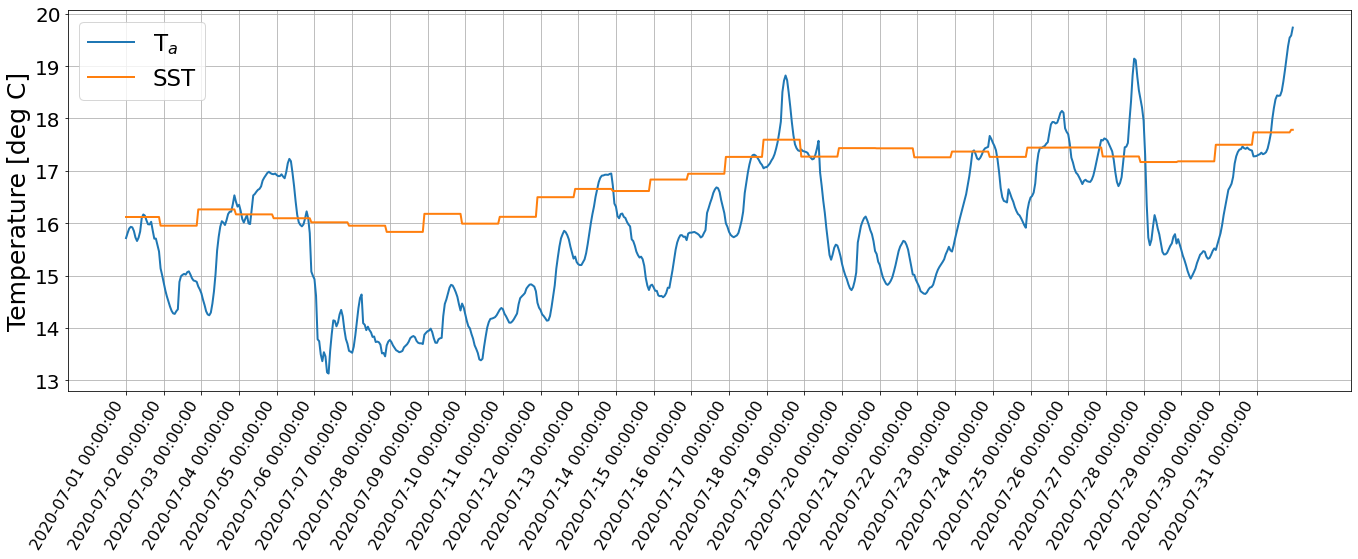

In [35]:
ta_Sc_C = ta_Sc - 273.15
sst_Sc_C = sst_Sc - 273.15 

plt.figure(figsize=(23,7))
plt.plot(ta_Sc_C,'-',linewidth=2,label='T$_a$')
plt.plot(sst_Sc_C,'-',linewidth=2,label='SST')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Temperature [deg C]',fontsize=25)
ax.set_xlabel('')
ax.legend(fontsize=23)

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'temp_time_series_202007_Sc.png') #, facecolor='white')

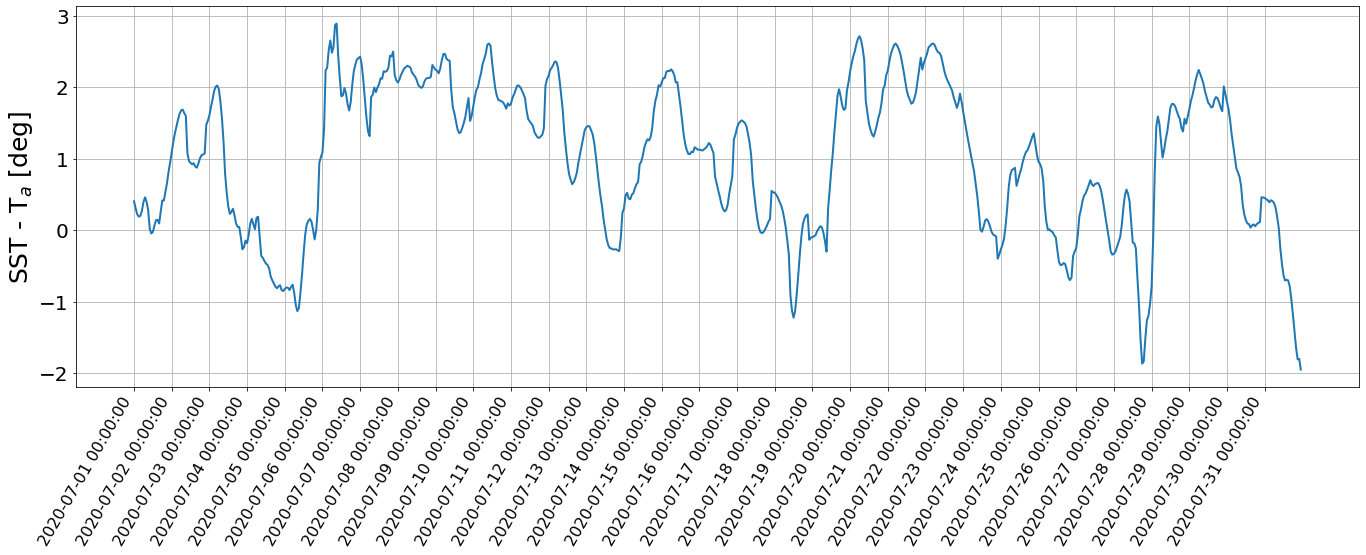

In [36]:
plt.figure(figsize=(23,7))
plt.plot(deltat_Sc,'-',linewidth=2,label='CAPE')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('SST - T$_a$ [deg]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'deltat_time_series_202007_Sc.png') #, facecolor='white')

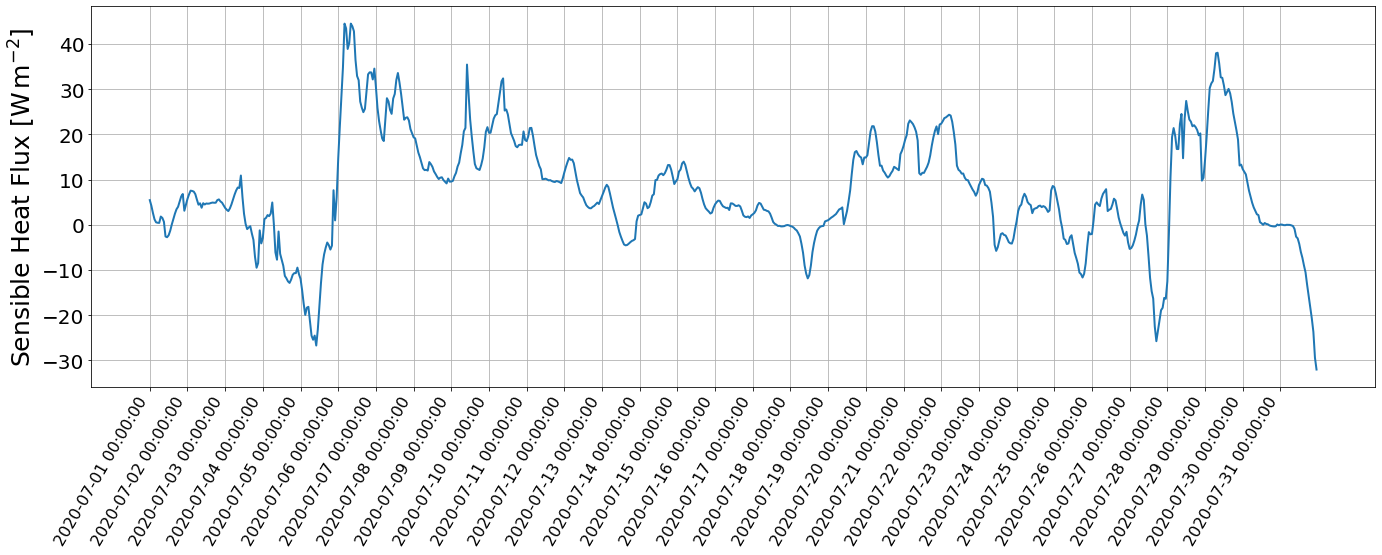

In [37]:
plt.figure(figsize=(23,7))
plt.plot(ishf_Sc,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Sensible Heat Flux [W$\/$m$^{-2}$]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'ishf_time_series_202007_Sc.png') #, facecolor='white')

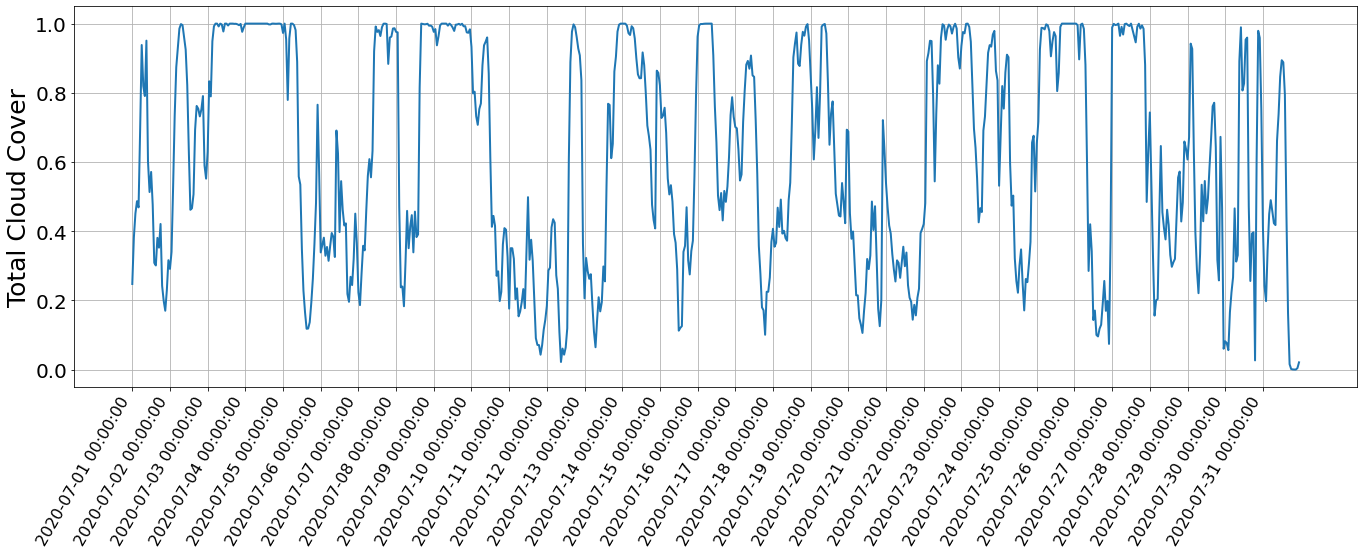

In [38]:
plt.figure(figsize=(23,7))
plt.plot(tcc_Sc,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Total Cloud Cover',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'tcc_time_series_202007_Sc.png') #, facecolor='white')

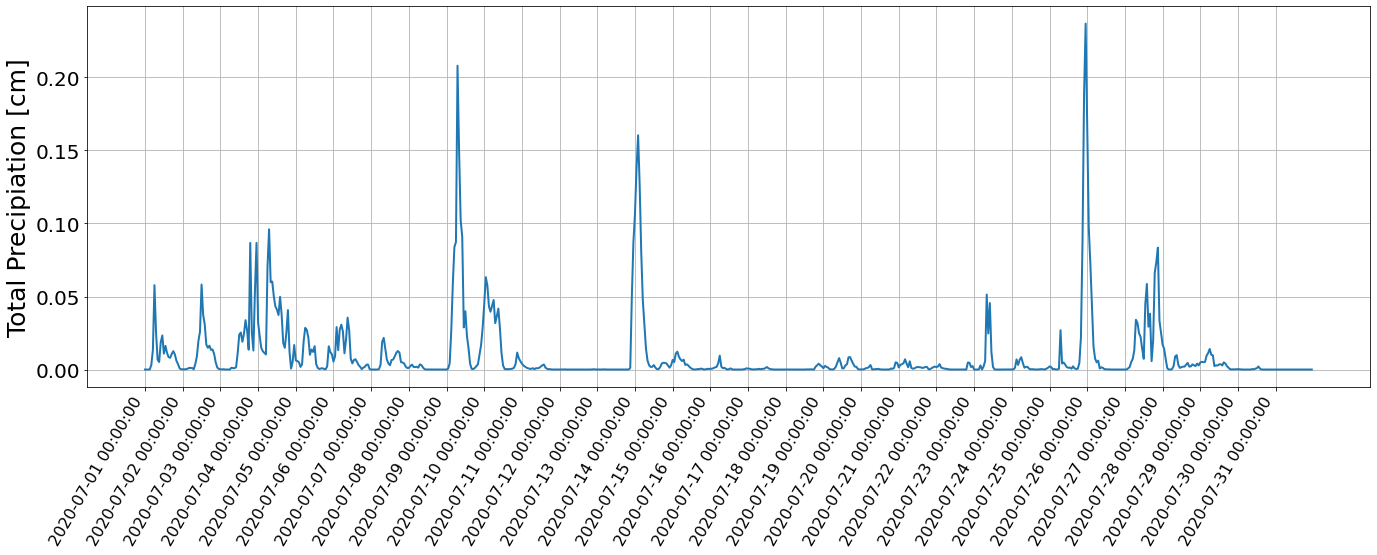

In [39]:
plt.figure(figsize=(23,7))
plt.plot(tp_Sc*100,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Total Precipiation [cm]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'tp_time_series_202007_Sc.png') #, facecolor='white')

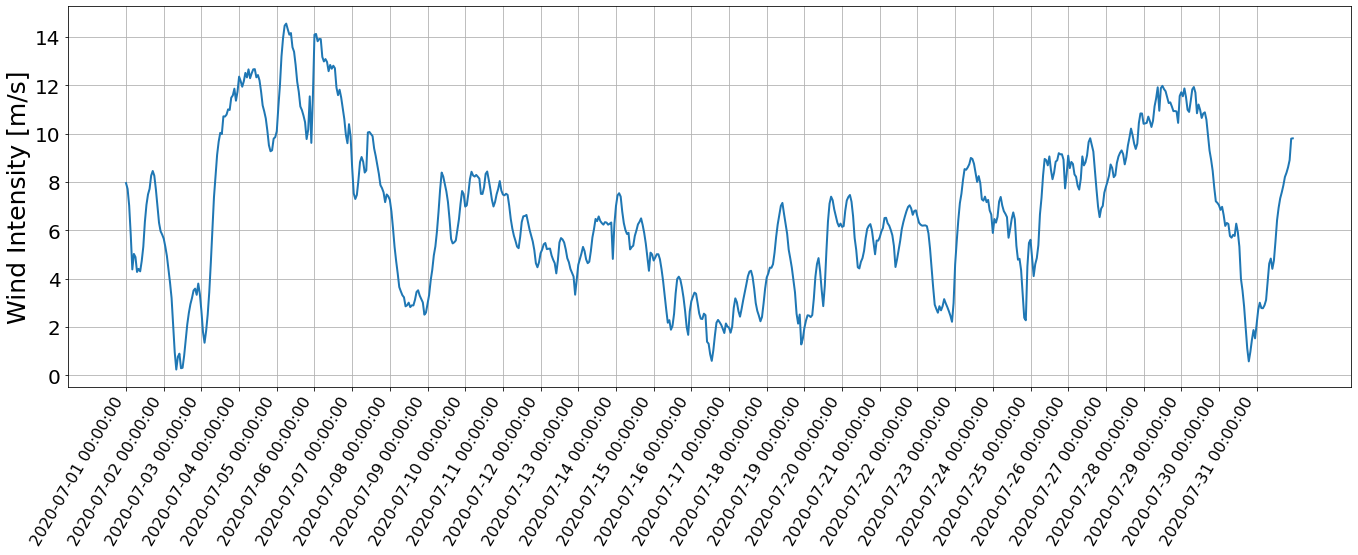

In [40]:
plt.figure(figsize=(23,7))
plt.plot(np.sqrt(u10m_Sc**2 + v10m_Sc**2),'-',linewidth=2,label='vel')

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Wind Intensity [m/s]',fontsize=25)
ax.set_xlabel('')
#ax.legend(fontsize=23)

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'wind_time_series_202007_Sc.png') #, facecolor='white')

C:\Users\leona\AppData\Local\Temp/ipykernel_2856/770693511.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(my_dates[time_idx[0]][t1:t2], rotation=60, ha='right',fontsize=16)


Text(0.5, 1.0, 'Wind speed and direction')

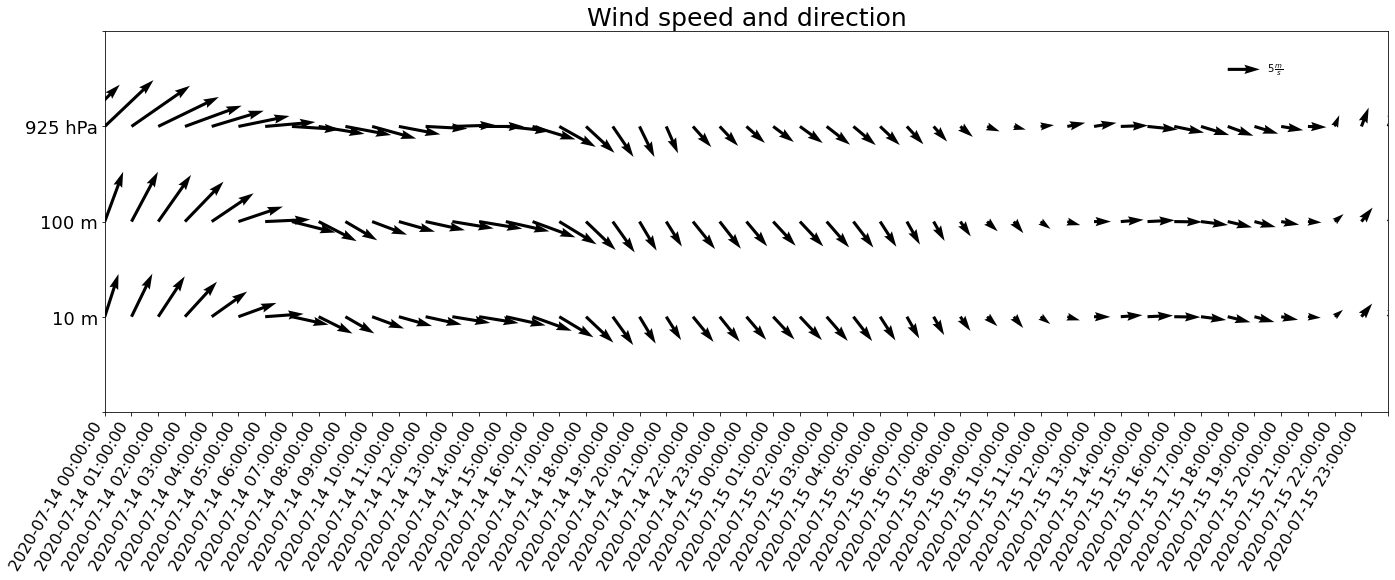

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots(1,1, figsize=(23,7))

t1 = 336 - 24
t2 = 336 + 24
numt = t2 - t1

Q = ax.quiver(x[:,0],y[:,0],u10m_Sc, v10m_Sc, pivot='tail',units='width',scale=200)
ax.quiverkey(Q, X=0.9, Y=0.9, U=5, label=r'$5\/\frac{m}{s}$',labelpos='E')
Q = ax.quiver(x[:,1],y[:,1],u100m_Sc, v100m_Sc, pivot='tail',units='width',scale=200)
Q = ax.quiver(x[:,2],y[:,2],u925_Sc, v925_Sc, pivot='tail',units='width',scale=200)

ax.set_xticklabels(my_dates[time_idx[0]][t1:t2], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=numt)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['','10 m','100 m','925 hPa',''],fontsize=18)

ax.set_ylim(0,4)
ax.set_xlim(t1,t2)
ax.set_title('Wind speed and direction',fontsize=25)

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'wind_speed_dir_time_series_202007_Sc.png') #, facecolor='white')

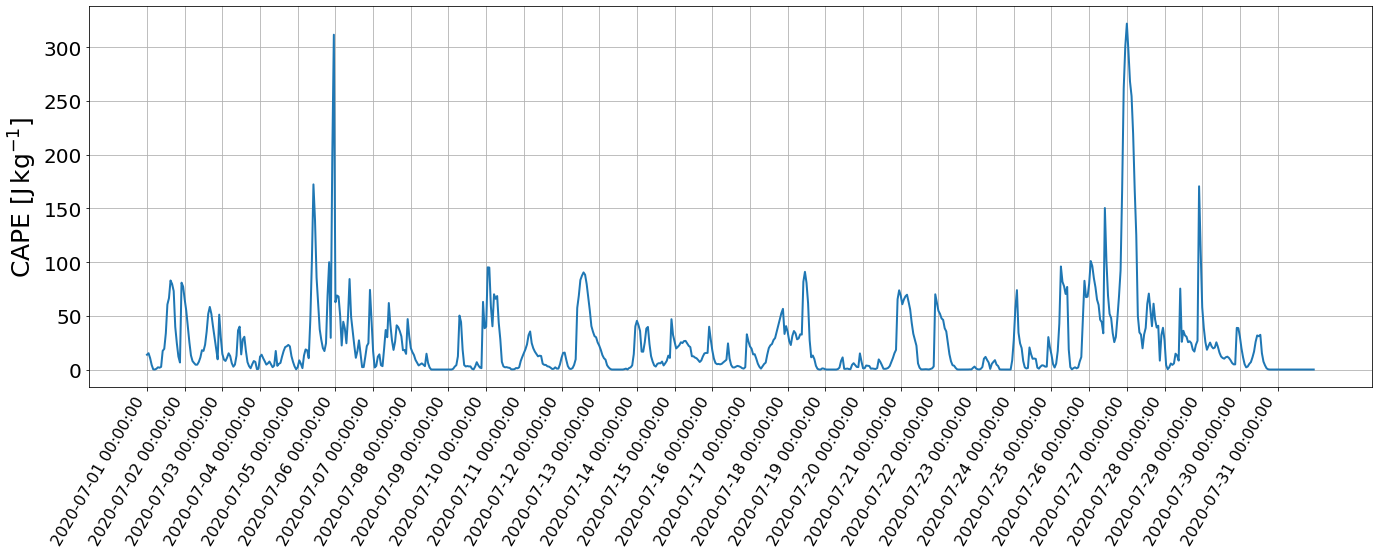

In [42]:
plt.figure(figsize=(23,7))
plt.plot(cape_Sc,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('CAPE [J$\/$kg$^{-1}$]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'cape_time_series_202007_Sc.png') #, facecolor='white')

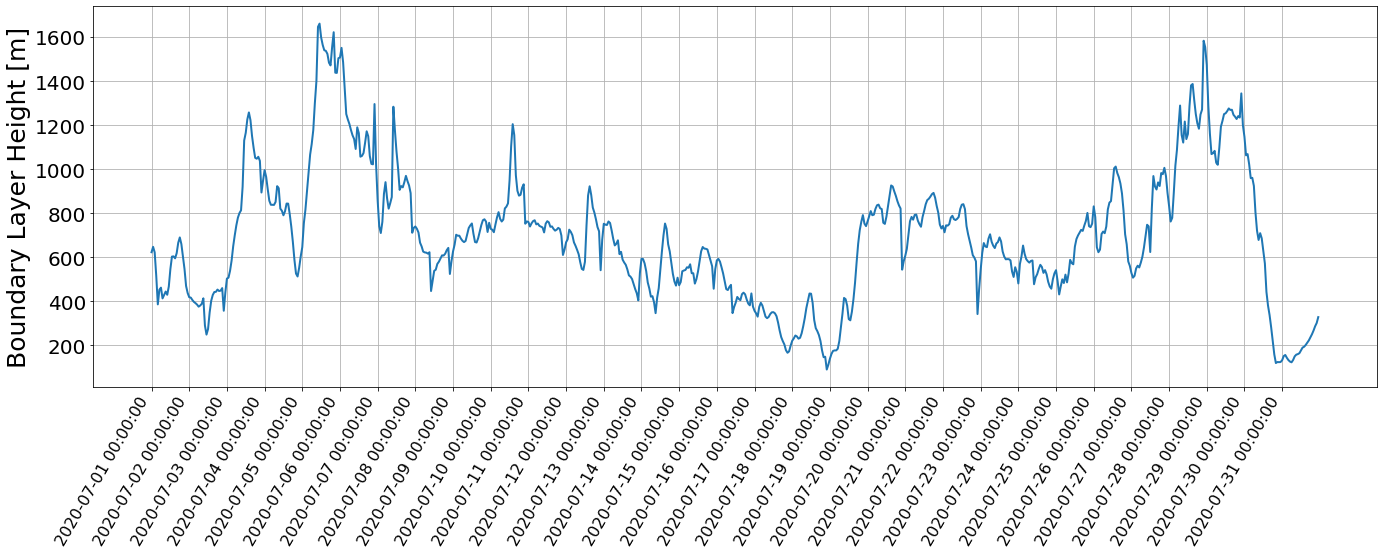

In [43]:
plt.figure(figsize=(23,7))
plt.plot(blh_Sc,'-',linewidth=2)

vec = np.arange(len(time_idx[0]))
ax = plt.gca()
ax.set_ylabel('Boundary Layer Height [m]',fontsize=25)
ax.set_xlabel('')

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=16)
plt.locator_params(axis='x', nbins=(31+1))
plt.grid()

#plt.tight_layout()
#plt.savefig(OUT_PATH + 'blh_time_series_202007_Sc.png') #, facecolor='white')

### Maps

In [44]:
### Choose a reference date.
### On 21-07-2020 soaring was observed in IJmuiden from both GPS and radar 
ref_date = datetime(2020,7,21,17,0,0)

time_idx = np.where(np.all([my_dates==ref_date],axis=0))
print(time_idx[0])

[4169]


In [45]:
ishf_NS = np.reshape(-ishf[time_idx[0],:,:],(14,16))
cape_NS = np.reshape(cape[time_idx[0],:,:],(14,16))
tp_NS = np.reshape(tp[time_idx[0],:,:],(14,16))
tcc_NS = np.reshape(tcc[time_idx[0],:,:],(14,16))
sst_NS = np.reshape(sst[time_idx[0],:,:],(14,16))-273.15
ta_NS = np.reshape(ta[time_idx[0],:,:],(14,16))-273.15
deltat_NS = sst_NS - ta_NS
u10m_NS = np.reshape(u10m[time_idx[0],:,:],(14,16)) 
v10m_NS = np.reshape(v10m[time_idx[0],:,:],(14,16)) 
vel10m_NS = np.sqrt(u10m_NS**2 + v10m_NS**2)

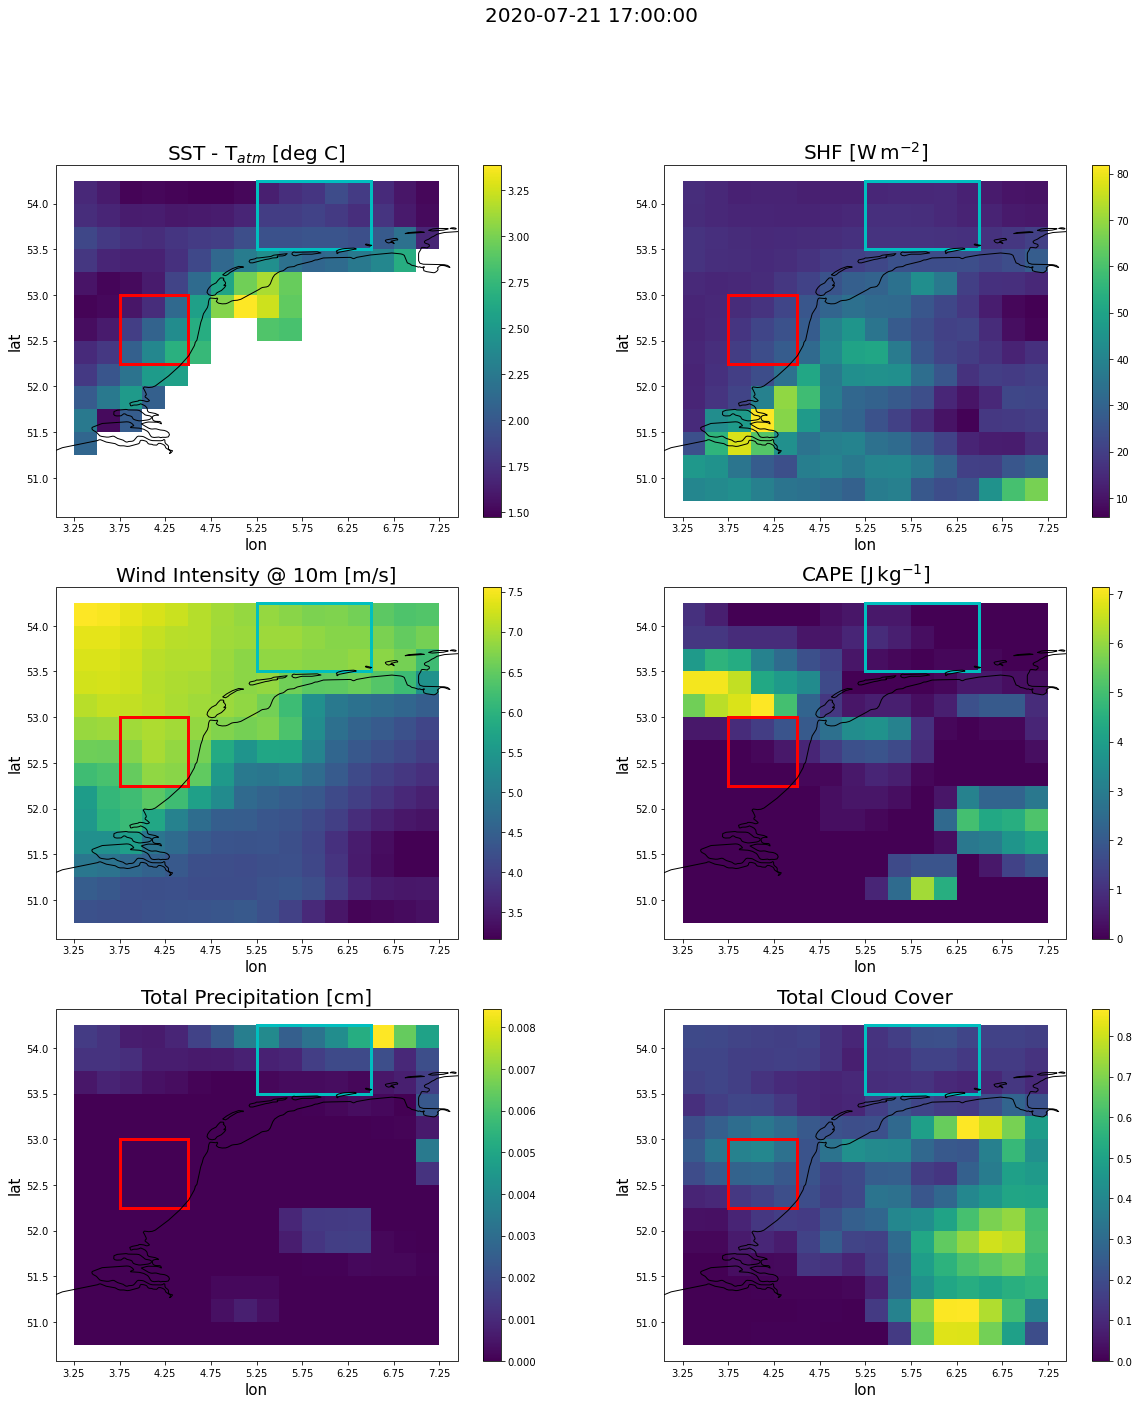

In [47]:
### Plot
plt.figure(figsize=(20,22))
plt.suptitle(str(my_dates[int(time_idx[0])]),fontsize=20)

ax = plt.subplot(321, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, deltat_NS) #, vmin=-250000, vmax=500000)
ax.set_title('SST - T$_{atm}$ [deg C]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(322, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, ishf_NS) #, vmin=-250000, vmax=500000)
ax.set_title('SHF [W$\/$m$^{-2}$]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(323, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, vel10m_NS) #, vmin=-250000, vmax=500000)
ax.set_title('Wind Intensity @ 10m [m/s]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()
rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(324, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, cape_NS) #, vmin=-250000, vmax=500000)
ax.set_title('CAPE [J$\/$kg$^{-1}$]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(325, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, tp_NS*100) #, vmin=-250000, vmax=500000)
ax.set_title('Total Precipitation [cm]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(326, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, tcc_NS) #, vmin=-250000, vmax=500000)
ax.set_title('Total Cloud Cover', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

The red box corresponds to the IJmuiden area and the blu box to the Schiermonnikoog area

### Plot wind at 925hPa map and windrose for IJmuiden and Schiermonnikoog

C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\leona\anaconda3\envs\myenv\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


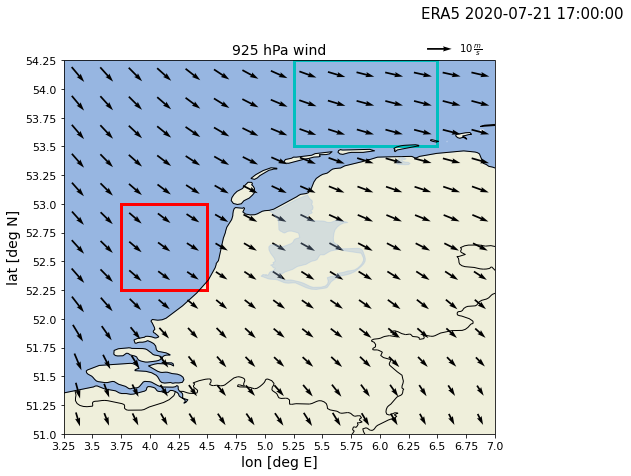

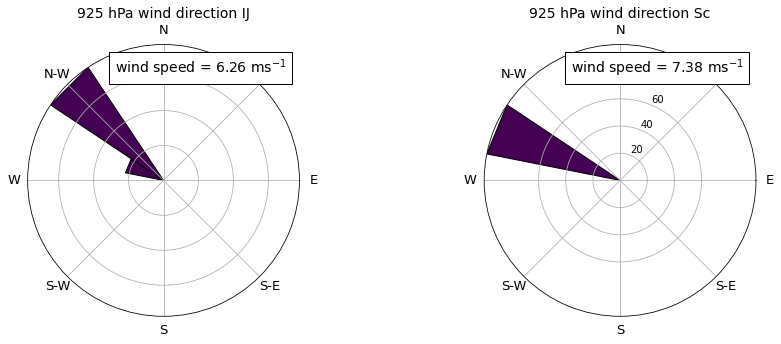

In [48]:
u925_NS = np.reshape(u_lev[time_idx[0],1,:,:],(14,16)) 
v925_NS = np.reshape(v_lev[time_idx[0],1,:,:],(14,16)) 

u10_NS = np.reshape(u10m[time_idx[0],:,:],(14,16)) 
v10_NS = np.reshape(v10m[time_idx[0],:,:],(14,16)) 

plt.figure(figsize=(17,7))

plt.suptitle('ERA5 ' + str(ref_date), fontsize = 15)

###quiver map
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.set_title('925 hPa wind', fontsize=14)

Q = ax1.quiver(lon+0.125, lat-0.125, u925_NS, v925_NS, units='width', pivot='middle')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(lat)-0.5, max(lat)+1, 0.25))
ax1.set_xticks(np.arange(min(lon)-0.5, max(lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(lat)-0.5, max(lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(lon)-0.5, max(lon)+1, 0.25), fontsize = 11)

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax1.add_patch(rect1)
ax1.add_patch(rect2)

ax1.set_xlim([min(lon), max(lon)])
ax1.set_ylim([min(lat), max(lat)])


u_uno_IJ = u_lev[time_idx[0],1,idx_lat_1[0],:]
u925_IJ = np.reshape(u_uno_IJ[:,idx_lon_1[0]],(3,3)) 
v_uno_IJ = v_lev[time_idx[0],1,idx_lat_1[0],:]
v925_IJ = np.reshape(v_uno_IJ[:,idx_lon_1[0]],(3,3)) 

u_uno_Sc = u_lev[time_idx[0],1,idx_lat_2[0],:]
u925_Sc = np.reshape(u_uno_Sc[:,idx_lon_2[0]],(3,5)) 
v_uno_Sc = v_lev[time_idx[0],1,idx_lat_2[0],:]
v925_Sc = np.reshape(v_uno_Sc[:,idx_lon_2[0]],(3,5)) 


plt.figure(figsize=(15,5))

###windrose
uu = u925_IJ
vv = v925_IJ
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(121, projection='windrose')
plt.title('925 hPa wind direction IJ', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('wind speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)



uu = u925_Sc
vv = v925_Sc
ws = np.sqrt(uu**2 + vv**2)

wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(122, projection='windrose')
plt.title('925 hPa wind direction Sc', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('wind speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

In [49]:
### On 15-07-2020 soaring was detected at Schiermonnikoog in both radar and GPS
ref_date = datetime(2020,7,15,17,0,0)

time_idx = np.where(np.all([my_dates==ref_date],axis=0))
print(time_idx[0])

[4025]


In [50]:
ishf_NS = np.reshape(-ishf[time_idx[0],:,:],(14,16))
cape_NS = np.reshape(cape[time_idx[0],:,:],(14,16))
tp_NS = np.reshape(tp[time_idx[0],:,:],(14,16))
tcc_NS = np.reshape(tcc[time_idx[0],:,:],(14,16))
sst_NS = np.reshape(sst[time_idx[0],:,:],(14,16))-273.15
ta_NS = np.reshape(ta[time_idx[0],:,:],(14,16))-273.15
deltat_NS = sst_NS - ta_NS
u10m_NS = np.reshape(u10m[time_idx[0],:,:],(14,16)) 
v10m_NS = np.reshape(v10m[time_idx[0],:,:],(14,16)) 
vel10m_NS = np.sqrt(u10m_NS**2 + v10m_NS**2)

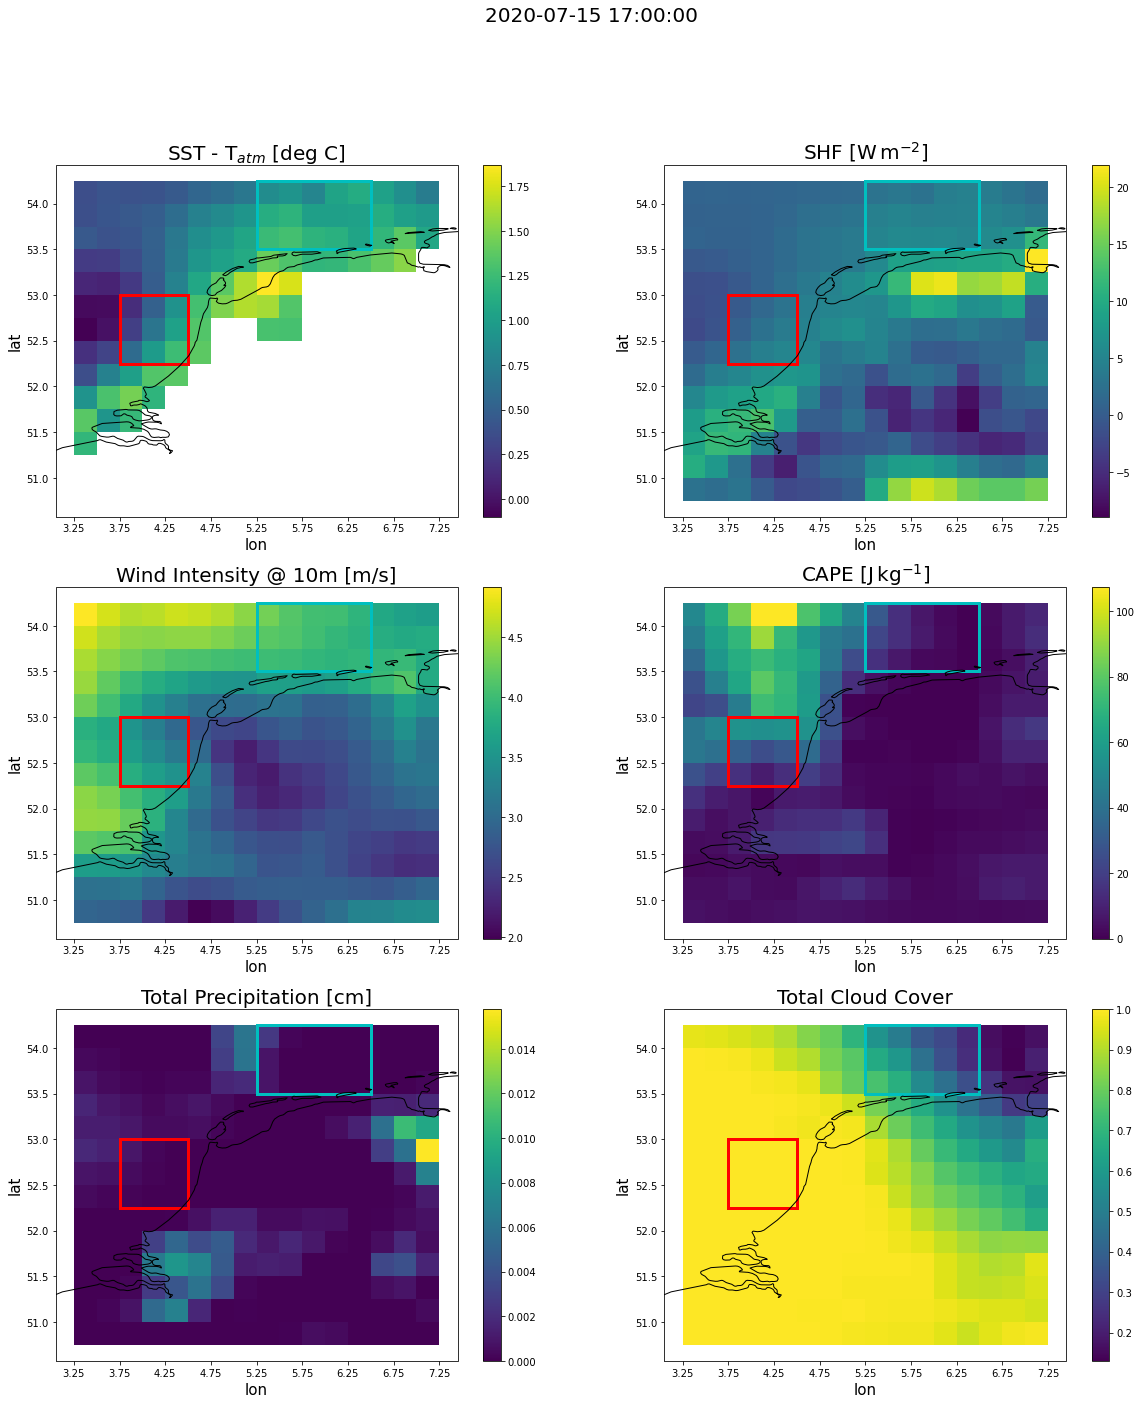

In [52]:
### Plot
plt.figure(figsize=(20,22))
plt.suptitle(str(my_dates[int(time_idx[0])]),fontsize=20)

ax = plt.subplot(321, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, deltat_NS) #, vmin=-250000, vmax=500000)
ax.set_title('SST - T$_{atm}$ [deg C]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(322, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, ishf_NS) #, vmin=-250000, vmax=500000)
ax.set_title('SHF [W$\/$m$^{-2}$]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(323, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, vel10m_NS) #, vmin=-250000, vmax=500000)
ax.set_title('Wind Intensity @ 10m [m/s]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()
rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(324, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, cape_NS) #, vmin=-250000, vmax=500000)
ax.set_title('CAPE [J$\/$kg$^{-1}$]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(325, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, tp_NS*100) #, vmin=-250000, vmax=500000)
ax.set_title('Total Precipitation [cm]', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)


ax = plt.subplot(326, projection=ccrs.PlateCarree())
c = ax.pcolormesh(lon+0.125, lat-0.125, tcc_NS) #, vmin=-250000, vmax=500000)
ax.set_title('Total Cloud Cover', fontsize = 20)
ax.set_ylabel('lat',fontsize=15)
ax.set_xlabel('lon',fontsize=15)
ax.set_yticks(np.arange(min(lat), max(lat)+0.25, 0.5))
ax.set_xticks(np.arange(min(lon), max(lon)+0.5, 0.5))
plt.colorbar(c, ax=ax)
ax.coastlines()

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

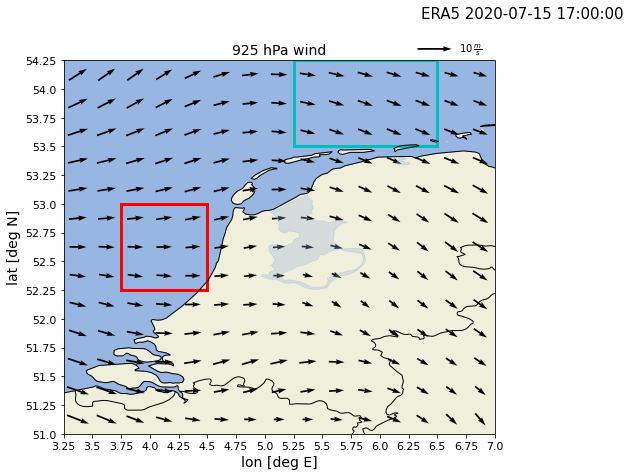

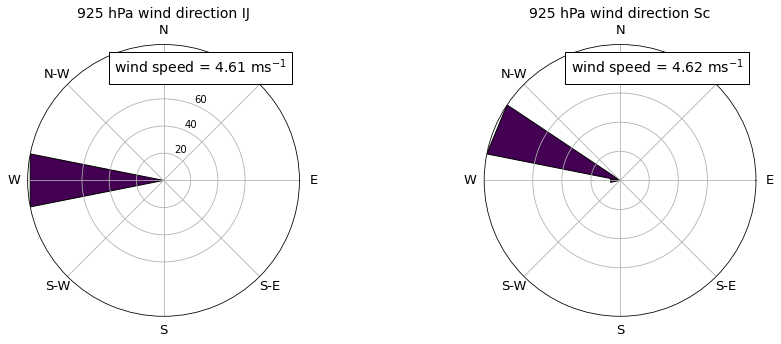

In [53]:
u925_NS = np.reshape(u_lev[time_idx[0],1,:,:],(14,16)) 
v925_NS = np.reshape(v_lev[time_idx[0],1,:,:],(14,16)) 

plt.figure(figsize=(17,7))

plt.suptitle('ERA5 ' + str(ref_date), fontsize = 15)

###quiver map
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.set_title('925 hPa wind', fontsize=14)

Q = ax1.quiver(lon+0.125, lat-0.125, u925_NS, v925_NS, units='width', pivot='middle')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(lat)-0.5, max(lat)+1, 0.25))
ax1.set_xticks(np.arange(min(lon)-0.5, max(lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(lat)-0.5, max(lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(lon)-0.5, max(lon)+1, 0.25), fontsize = 11)

rect1 = patches.Rectangle((3.75,52.25),0.75,0.75,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((5.25,53.5),1.25,0.75,linewidth=3,edgecolor='c',facecolor='none')
ax1.add_patch(rect1)
ax1.add_patch(rect2)

ax1.set_xlim([min(lon), max(lon)])
ax1.set_ylim([min(lat), max(lat)])


u_uno_IJ = u_lev[time_idx[0],1,idx_lat_1[0],:]
u925_IJ = np.reshape(u_uno_IJ[:,idx_lon_1[0]],(3,3)) 
v_uno_IJ = v_lev[time_idx[0],1,idx_lat_1[0],:]
v925_IJ = np.reshape(v_uno_IJ[:,idx_lon_1[0]],(3,3)) 

u_uno_Sc = u_lev[time_idx[0],1,idx_lat_2[0],:]
u925_Sc = np.reshape(u_uno_Sc[:,idx_lon_2[0]],(3,5)) 
v_uno_Sc = v_lev[time_idx[0],1,idx_lat_2[0],:]
v925_Sc = np.reshape(v_uno_Sc[:,idx_lon_2[0]],(3,5)) 


plt.figure(figsize=(15,5))

###windrose
uu = u925_IJ
vv = v925_IJ
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(121, projection='windrose')
plt.title('925 hPa wind direction IJ', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('wind speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)



uu = u925_Sc
vv = v925_Sc
ws = np.sqrt(uu**2 + vv**2)

wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(122, projection='windrose')
plt.title('925 hPa wind direction Sc', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('wind speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

### Calculation of SHF

**Variables I need**

In [54]:
### u2/u1 = (z2/z1)^P                     Power law with P=0.11 at sea, Hsu et al. (1993)
u2m = u10m*((2/10)**0.11)                 #2m u component
v2m = v10m*((2/10)**0.11)                 #2m v component
vel = np.sqrt(u2m**2 + v2m**2)            #2m velocity 
print(np.shape(vel))

sstc = sst - 273.15
tac = ta - 273.15
print(np.shape(sst))
print(np.shape(ta))

(4416, 14, 16)
(4416, 14, 16)
(4416, 14, 16)


**Formulas**

In [55]:
### formula 1
#Rate of sensible heat loss from ocean surface by convection and conduction [W/m2]
#this numbers are valid for Pacific Ocean, Mohammed Faizal & Ahmed (2011)
Qh = 1.88*vel*(sst-ta)
print(np.shape(Qh))

### formula 2
# Convection and conduction heat flux [W/m2]
#valid mostly for lakes and rivers, Kalinowska (2019)
#function of wind: Brady et al. (1969), Ahsan and Blumberg (1999), Arifin et al. (2016) and Ji (2008)
cb = 0.62 #[mb/degC]
p0 = 1013 #[mb]
f_u = 6.9 + 0.34*(vel**2) #[W m-2 mb-1]
H = cb*(pa/(100*p0))*f_u*(sst-ta)
print(np.shape(H))

(4416, 14, 16)
(4416, 14, 16)


**Calculate time series of Qh, H, and SSHF**

In [56]:
#time series for over locations for interval
ref_date_1 = datetime(2020,7,1,0,0,0)
ref_date_2 = datetime(2020,7,31,23,0,0)

time_idx = np.where(np.all([my_dates>=ref_date_1,my_dates<=ref_date_2],axis=0))

In [57]:
ishf_uno = np.average(-ishf[:,:,idx_lon_1[0]],axis=2)
ishf_due = np.average(ishf_uno[:,idx_lat_1[0]],axis=1)
ishf_IJ = ishf_due[time_idx[0]]

Qh_uno = np.average(Qh[:,:,idx_lon_1[0]],axis=2)
Qh_due = np.average(Qh_uno[:,idx_lat_1[0]],axis=1)
Qh_IJ = Qh_due[time_idx[0]]

H_uno = np.average(H[:,:,idx_lon_1[0]],axis=2)
H_due = np.average(H_uno[:,idx_lat_1[0]],axis=1)
H_IJ = H_due[time_idx[0]]

ishf_uno = np.average(-ishf[:,:,idx_lon_2[0]],axis=2)
ishf_due = np.average(ishf_uno[:,idx_lat_2[0]],axis=1)
ishf_Sc = ishf_due[time_idx[0]]

Qh_uno = np.average(Qh[:,:,idx_lon_2[0]],axis=2)
Qh_due = np.average(Qh_uno[:,idx_lat_2[0]],axis=1)
Qh_Sc = Qh_due[time_idx[0]]

H_uno = np.average(H[:,:,idx_lon_2[0]],axis=2)
H_due = np.average(H_uno[:,idx_lat_2[0]],axis=1)
H_Sc = H_due[time_idx[0]]


deltat = sst - ta
deltat_uno = np.average(deltat[:,:,idx_lon_1[0]],axis=2)
deltat_due = np.average(deltat_uno[:,idx_lat_1[0]],axis=1)
deltat_IJ = deltat_due[time_idx[0]]

deltat_uno = np.average(deltat[:,:,idx_lon_2[0]],axis=2)
deltat_due = np.average(deltat_uno[:,idx_lat_2[0]],axis=1)
deltst_Sc = deltat_due[time_idx[0]]

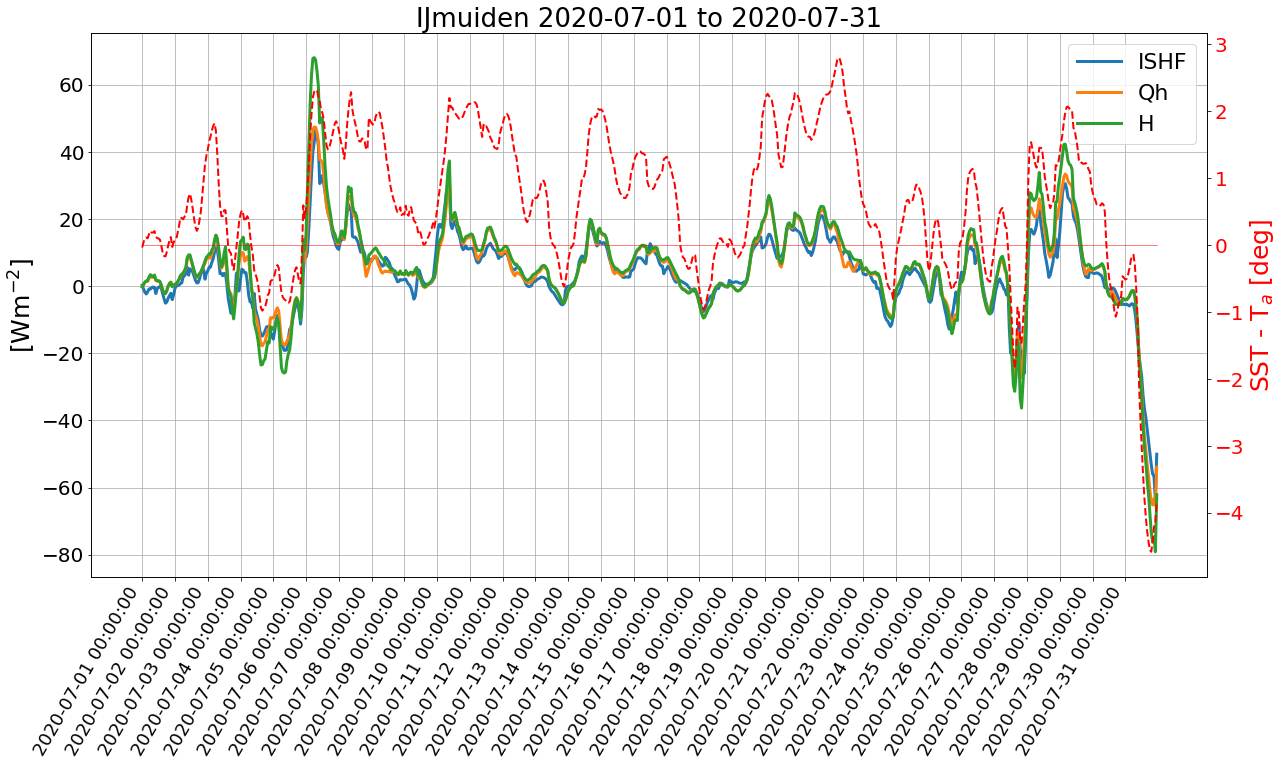

In [58]:
### Plot
plt.figure(figsize=(20,10))
plt.plot(ishf_IJ,'-',linewidth=3,label='ISHF')
plt.plot(Qh_IJ,'-',linewidth=3,label='Qh')
plt.plot(H_IJ,'-',linewidth=3,label='H')
plt.legend(fontsize=22)
vec = np.arange(len(time_idx[0]))
vec_const = 0*vec

ax = plt.gca()
ax.set_ylabel('[Wm$^{-2}$]',fontsize=25)
ax.set_xlabel('')
plt.title('IJmuiden '+str(ref_date_1.date())+' to '+str(ref_date_2.date()), fontsize=26)
#ax.set_ylim(-50, 75)

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
plt.grid()
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=18)
plt.locator_params(axis='x', nbins=31+1)

### make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(deltat_IJ,'--',linewidth=2,label='SST - T$_a$', color = 'r')
ax2.set_ylabel("SST - T$_a$ [deg]",color="red",fontsize=25)
plt.yticks(fontsize=20, color='r')
plt.plot(vec,vec_const,'-r', linewidth=0.5)


### Uncomment here to save plot
#OUT_PATH = '/home/leo/Dropbox/UvA/North Sea/Plots/Notebook/'
#plt.tight_layout()
#plt.savefig(OUT_PATH + 'shf_time_series_202007_IJ.png') #, facecolor='white')

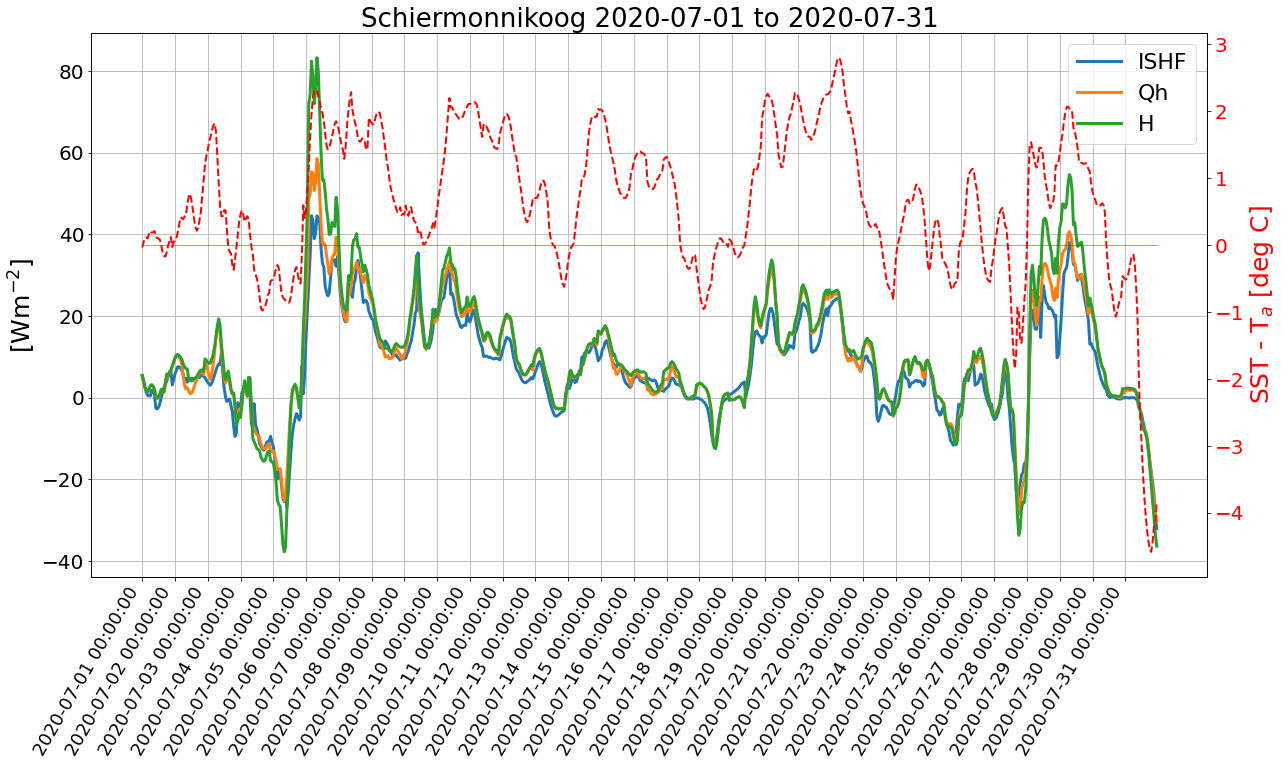

In [60]:
### Plot
plt.figure(figsize=(20,10))
plt.plot(ishf_Sc,'-',linewidth=3,label='ISHF')
plt.plot(Qh_Sc,'-',linewidth=3,label='Qh')
plt.plot(H_Sc,'-',linewidth=3,label='H')
plt.legend(fontsize=22)
vec = np.arange(len(time_idx[0]))
vec_const = 0*vec

ax = plt.gca()
ax.set_ylabel('[Wm$^{-2}$]',fontsize=25)
ax.set_xlabel('')
plt.title('Schiermonnikoog '+str(ref_date_1.date())+' to '+str(ref_date_2.date()), fontsize=26)
#ax.set_ylim(-50, 75)

plt.xticks(vec, fontsize=20)  
plt.yticks(fontsize=20)
plt.grid()
ax.set_xticklabels(my_dates[time_idx[0]], rotation=60, ha='right',fontsize=18)
plt.locator_params(axis='x', nbins=31+1)

### make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(deltat_IJ,'--',linewidth=2,label='SST - T$_a$', color = 'r')
ax2.set_ylabel("SST - T$_a$ [deg C]",color="red",fontsize=25)
plt.yticks(fontsize=20, color='r')
plt.plot(vec,vec_const,'-r', linewidth=0.5)


#plt.tight_layout()
#plt.savefig(OUT_PATH + 'shf_time_series_202007_Sc.png') #, facecolor='white')